# Whisper Clustering for Topic

In [1]:
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from hdbscan import HDBSCAN
from umap import UMAP
import logging
from loguru import logger
import inspect
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer
from transformers.pipelines.base import KeyDataset
from transformers import BertTokenizerFast, AutoTokenizer, AutoModelForTokenClassification, pipeline, AutoModelForSequenceClassification
import pandas as pd
import os
from unidecode import unidecode
import pickle
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

if sys.platform.startswith('linux'):
    SYSTEM='linux'
elif sys.platform.startswith('darwin'):
    SYSTEM='mac'
else:
    print("You are on a different system: ", sys.platform)

hashtags = [
    "metoo", "BalanceTonPorc", "MoiAussi", "نه_یعنی_نه", "米兔", "我也是", 
    "وأنا كمان", "GamAni", "TôiCũngVậy", "私も", "WatashiMo", "나도", 
    "나도당했다", "גםאנחנו", "Ятоже", "RiceBunny", "EnaZeda", "AnaKaman", 
    "YoTambien", "SendeAnlat", "KuToo", "WithYou", "WeToo", "cuentalo", 
    "QuellaVoltaChe", "NiUnaMenos", "WoYeShi", "MyHarveyWeinstein", 
    "NousToutes", "stilleforopptak", "nårdansenstopper", "nårmusikkenstilner", 
    "memyös", "timesup", "NiEre", "JoTambe", "미투", "운동",
    'sexual', 'violence', 'assault'
]

class InterceptHandler(logging.Handler):
    def emit(self, record: logging.LogRecord) -> None:
        # Get corresponding Loguru level if it exists.
        level: str | int
        try:
            level = logger.level(record.levelname).name
        except ValueError:
            level = record.levelno

        # Find caller from where originated the logged message.
        frame, depth = inspect.currentframe(), 0
        while frame and (depth == 0 or frame.f_code.co_filename == logging.__file__):
            frame = frame.f_back
            depth += 1

        logger.opt(depth=depth, exception=record.exc_info).log(level, record.getMessage())

logging.basicConfig(handlers=[InterceptHandler()], level=0, force=True)
logging.getLogger('bertopic').setLevel(logging.DEBUG)
logging.getLogger('numba').setLevel(logging.ERROR)
logging.getLogger('matplotlib').setLevel(logging.ERROR)

plot_path = Path('../local_nogit/Data/plots')

In [2]:
##### SET THIS

YT_or_TT = 'YT'
overwrite = False

######
logger.info(f'Loading in {YT_or_TT}')

# load in data
data_path_arc = Path('/data/inet-large-scale-twitter-diffusion/ball4321/data_c/')
data_path_local= '../local_nogit/Data/'

DATA_PATH = Path(f'{data_path_arc if SYSTEM == "linux" else data_path_local}')
logger.info(f'DATA PATH SET TO {DATA_PATH}')

df = pd.read_parquet(DATA_PATH / f"{'YT' if YT_or_TT == 'YT' else 'TikTok/01_raw'}/{'audio' if YT_or_TT == 'YT' else 'videos'}_transcribed.parquet")


### Manual addition: remove illegal row
if YT_or_TT == 'YT':

    # insert link column:
    df['link'] = df['videoId'].apply(lambda x: f'https://www.youtube.com/watch?v={x}')
    logger.info(f'Created link column for YT')


csv_path = DATA_PATH / f"{'YT' if YT_or_TT == 'YT' else 'TikTok/01_raw'}/{'audio' if YT_or_TT == 'YT' else 'videos'}_transcribed.xlsx"
if not os.path.isfile(csv_path) or overwrite:
    df.to_excel(csv_path, engine='xlsxwriter')
    logger.info(f'Saved to {csv_path}')


2024-04-02 12:09:59.723 | INFO     | __main__:<module>:7 - Loading in YT
2024-04-02 12:09:59.724 | INFO     | __main__:<module>:14 - DATA PATH SET TO ../local_nogit/Data
2024-04-02 12:09:59.851 | INFO     | __main__:<module>:24 - Created link column for YT


In [3]:
df.columns

Index(['channelId', 'channelTitle', 'videoId', 'publishedAt', 'publishedAtSQL',
       'videoTitle', 'videoDescription', 'tags', 'videoCategoryId',
       'videoCategoryLabel', 'topicCategories', 'duration', 'durationSec',
       'dimension', 'definition', 'caption', 'defaultLanguage',
       'defaultLAudioLanguage', 'thumbnail_maxres', 'licensedContent',
       'locationDescription', 'latitude', 'longitude', 'viewCount',
       'likeCount', 'dislikeCount', 'favoriteCount', 'commentCount', 'text',
       'link'],
      dtype='object')

In [4]:
stopword_list_savepath = DATA_PATH/'YT/stopwords.pkl'

if not os.path.isfile(stopword_list_savepath) or overwrite:

    from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
    from spacy.lang.en.stop_words import STOP_WORDS as en_stop
    from spacy.lang.hi.stop_words import STOP_WORDS as hi_stop
    from spacy.lang.de.stop_words import STOP_WORDS as de_stop
    from spacy.lang.es.stop_words import STOP_WORDS as es_stop
    from spacy.lang.ca.stop_words import STOP_WORDS as ca_stop
    from spacy.lang.fi.stop_words import STOP_WORDS as fi_stop
    from spacy.lang.pl.stop_words import STOP_WORDS as pl_stop
    from spacy.lang.ur.stop_words import STOP_WORDS as ur_stop
    from spacy.lang.fa.stop_words import STOP_WORDS as fa_stop
    from spacy.lang.hu.stop_words import STOP_WORDS as hu_stop
    from spacy.lang.ko.stop_words import STOP_WORDS as ko_stop
    from spacy.lang.tr.stop_words import STOP_WORDS as tr_stop
    from spacy.lang.ro.stop_words import STOP_WORDS as ro_stop
    from spacy.lang.it.stop_words import STOP_WORDS as it_stop
    from spacy.lang.nl.stop_words import STOP_WORDS as nl_stop
    from spacy.lang.zh.stop_words import STOP_WORDS as zh_stop
    from spacy.lang.ja.stop_words import STOP_WORDS as ja_stop
    from spacy.lang.id.stop_words import STOP_WORDS as id_stop
    from spacy.lang.ar.stop_words import STOP_WORDS as ar_stop
    from spacy.lang.pt.stop_words import STOP_WORDS as pt_stop
    from spacy.lang.vi.stop_words import STOP_WORDS as vi_stop
    from spacy.lang.la.stop_words import STOP_WORDS as la_stop
    from spacy.lang.gu.stop_words import STOP_WORDS as gu_stop
    from spacy.lang.sr.stop_words import STOP_WORDS as sr_stop

    final_stopwords_list = list(fr_stop) \
        + list(en_stop) \
        + list(hi_stop) \
        + list(de_stop) \
        + list(es_stop) \
        + list(ca_stop) \
        + list(fi_stop) \
        + list(pl_stop) \
        + list(ur_stop) \
        + list(fa_stop) \
        + list(hu_stop) \
        + list(ko_stop) \
        + list(tr_stop) \
        + list(ro_stop) \
        + list(it_stop) \
        + list(nl_stop) \
        + list(zh_stop) \
        + list(ja_stop) \
        + list(id_stop) \
        + list(ar_stop) \
        + list(pt_stop) \
        + list(vi_stop) \
        + list(la_stop) \
        + list(gu_stop) \
        + list(sr_stop)

    print(len(final_stopwords_list))

    with open(stopword_list_savepath, 'wb') as f:
        pickle.dump(final_stopwords_list, f)

    logger.info(f'Saved to {stopword_list_savepath}')

else:

    with open(stopword_list_savepath, 'rb') as f:
        final_stopwords_list = pickle.load(f)

    logger.info(f'Loaded in stopwords from {stopword_list_savepath}')

2024-04-02 12:09:59.872 | INFO     | __main__:<module>:69 - Loaded in stopwords from ../local_nogit/Data/YT/stopwords.pkl


## Sandbox

distribution of languages in descriptions

In [5]:
if YT_or_TT== 'YT':
    print(df['defaultLAudioLanguage'].value_counts().head(20))
else:
    df['description_lang'].value_counts()
    len(df['music_matchedsong_idstr'].unique())
    df[df['description'].apply(lambda x: '' in x.lower())]
    type(df['description'].str.lower())
    df[df['description'].apply(lambda x: 'metoo' in x.lower())][:30]

defaultLAudioLanguage
en        604
hi        476
en-US     441
en-IN     139
ko        114
sr         70
en-GB      68
fr         66
ta         64
zxx        55
es-419     42
es         40
zh-TW      34
ml         30
tr         30
ur         30
de         25
de-DE      24
ar         23
en-CA      18
Name: count, dtype: int64


# Data Cleaning

In [6]:
keywords_to_remove={

    'TT': [
        'Meghan Trainor',
        'Trainor',
        'toothpaste',
        'angele',
        'trendingdance',
        '#미투챌린지',
        '#metoocallenge',
        '#exercise',
        '#dance'
    ],

    'YT':[
        '#apdhillon',
        'AP Dhillon',
        '#chinesefood',
        '#food',
        '#dance',
        'toothpaste',
        'angele',
        'trendingdance',
        '#미투챌린지',
        '#metoocallenge',
        'Trainor',
        'minecraft',
        'roblox',
        'meghantrainor'
    ]
}

keywords = keywords_to_remove[YT_or_TT]

# temp = df['description'].apply(lambda x: any(kw.lower() in x.lower() for kw in keywords))

def kw_clean_ind(df, kws, exclude=None, YT_or_TT='TT'):

    if YT_or_TT == 'TT':
        if exclude is not None: 
            logger.info(f'Exclusion Applied. Original len: {len(df)}. Truncated: {len(df[~exclude])}')
            ind = df[~exclude]['description'].apply(lambda x: not any([
                    kw.lower() in unidecode(x.lower()) for kw in kws
            ]))
        else:
            ind = df['description'].apply(lambda x: not any([
                    kw.lower() in unidecode(x.lower()) for kw in kws
            ]))
    else:
        if exclude is not None:
            logger.info(f'Exclusion Applied. Original len: {len(df)}. Truncated: {len(df[~exclude])}')
            ind = df[~exclude].apply(lambda x: not any([
                    kw.lower() in unidecode(x[z].lower()) if x[z] else False for kw in kws for z in ['videoTitle', 'videoDescription', 'tags', 'text']]), axis=1)
        else:
            ind = df.apply(lambda x: not any([
                    kw.lower() in unidecode(x[z].lower()) if x[z] else False for kw in kws for z in ['videoTitle', 'videoDescription', 'tags', 'text']]), axis=1)
    return ind

In [7]:
df.columns

Index(['channelId', 'channelTitle', 'videoId', 'publishedAt', 'publishedAtSQL',
       'videoTitle', 'videoDescription', 'tags', 'videoCategoryId',
       'videoCategoryLabel', 'topicCategories', 'duration', 'durationSec',
       'dimension', 'definition', 'caption', 'defaultLanguage',
       'defaultLAudioLanguage', 'thumbnail_maxres', 'licensedContent',
       'locationDescription', 'latitude', 'longitude', 'viewCount',
       'likeCount', 'dislikeCount', 'favoriteCount', 'commentCount', 'text',
       'link'],
      dtype='object')

### YT Analysis Common Setup

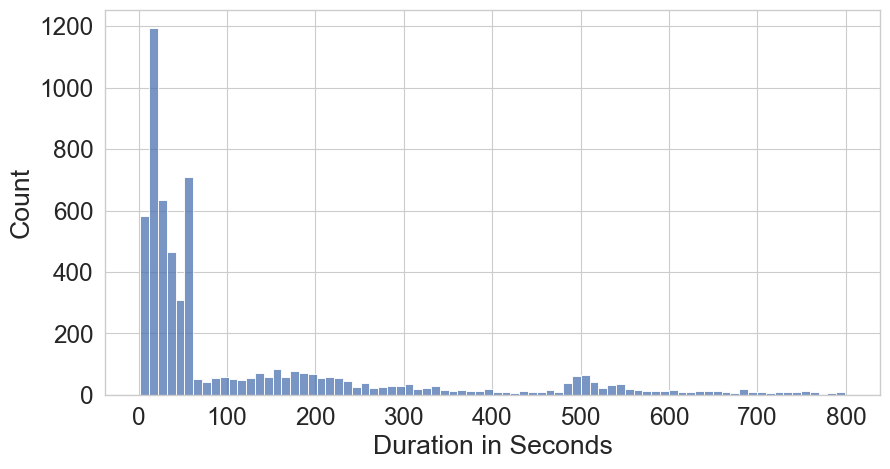

In [8]:
# PLOT: DURATION OF VIDEOS

fig = plt.figure(figsize=(10,5))
sns.set_theme(context='paper',style='whitegrid', font_scale=2)
# df['durationSec'].hist(bins=30)
sns.histplot(
    data=df.query('durationSec < 800'),
    x = 'durationSec',
    binwidth=10
    # log_scale=True
)
plt.xlabel('Duration in Seconds')
plt.savefig(plot_path / 'YT_dist_dur.png', bbox_inches='tight', dpi=800)

In [9]:
df_shorts_savepath = DATA_PATH / 'YT/df_long.parquet'
df_long_savepath = DATA_PATH / 'YT/df_shorts.parquet'

if (not os.path.isfile(df_shorts_savepath) or not os.path.isfile(df_long_savepath)) or overwrite:


    # check YT how many have hastags
    only_ht_ind = df.apply(lambda x: any([h.lower() in x[z].lower() if x[z] else False for h in hashtags for z in ['videoTitle', 'videoDescription', 'tags', 'text']]), axis=1)
    logger.info(f'Number of entries out of {len(df)} containing ht: {only_ht_ind.sum()}')

    # remove by kw
    yt_out_ind = kw_clean_ind(df, keywords, exclude = ~only_ht_ind, YT_or_TT=YT_or_TT)
    logger.info(f'cleaned df len: {len(df[only_ht_ind][yt_out_ind])}')


    # separate by shorts and longform
    logger.info(f'Separating out Shorts and longform videos')
    SHORT_TAGS = df[only_ht_ind][yt_out_ind]['tags'].apply(lambda x: 'shorts' in x if x else False) 
    logger.info(f'Tags: {SHORT_TAGS.sum()}')
    SHORT_TITLE = df[only_ht_ind][yt_out_ind]['videoTitle'].apply(lambda x: 'shorts' in x if x else False)
    logger.info(f'Title: {SHORT_TITLE.sum()}')
    SHORT_DESC = df[only_ht_ind][yt_out_ind]['videoDescription'].apply(lambda x: 'shorts' in x if x else False)
    logger.info(f'Desription: {SHORT_DESC.sum()}')
    SHORT_COMB = SHORT_DESC | SHORT_TAGS | SHORT_TITLE
    logger.info(f'Combined: {SHORT_COMB.sum()}')

    # finalise separation
    df_shorts = df[only_ht_ind][yt_out_ind][SHORT_COMB]
    df_long   = df[only_ht_ind][yt_out_ind][~SHORT_COMB]

    # combine title and description for option in clustering

    # must use 'query: ' prefix for clustering embeddings. cf. 
    df_long['t'] = df['text'].apply(lambda x: f'query: {x}' if x else '')
    df_long['ti'] = df['videoTitle'].apply(lambda x: f'query: {x}' if x else '')
    df_long['d'] = df['videoDescription'].apply(lambda x: f'query: {x}' if x else '')
    df_long['td'] = df.apply(lambda x: 'query: ' + f"{x['videoTitle'] if x['videoTitle'] else ''}" + f"{x['videoDescription'] if x['videoDescription'] else ''}", axis=1)
    df_long['tdt'] = df.apply(lambda x: 'query: ' + f"{x['videoTitle'] if x['videoTitle'] else ''}" + f"{x['videoDescription'] if x['videoDescription'] else ''}" + f"{x['text'] if x['text'] else ''}", axis=1)

    logger.info(f'Shorts separated out: {len(df_shorts)}')
    logger.info(f'Longform separated out: {len(df_long)}')

    df_long.to_parquet(df_long_savepath)
    logger.info(f'Saved to {df_long_savepath}')
    df_shorts.to_parquet(df_shorts_savepath)
    logger.info(f'Saved to {df_shorts_savepath}')

else:

    df_long = pd.read_parquet(df_long_savepath)
    logger.info(f'Loaded in from  {df_long_savepath}')
    df_shorts = pd.read_parquet(df_shorts_savepath)
    logger.info(f'Loaded in from  {df_shorts_savepath}')

df_long['videoId'] = df_long['videoId'].astype('string')
df_shorts['videoId'] = df_shorts['videoId'].astype('string')
df_long = df_long.set_index('videoId')
df_shorts = df_shorts.set_index('videoId')

2024-04-02 12:10:12.360 | INFO     | __main__:<module>:51 - Loaded in from  ../local_nogit/Data/YT/df_shorts.parquet
2024-04-02 12:10:12.368 | INFO     | __main__:<module>:53 - Loaded in from  ../local_nogit/Data/YT/df_long.parquet


### YT First Analysis

In [10]:
seed = 0

langcounts = df_shorts['defaultLanguage'].value_counts()>=10
langcounts_l = df_long['defaultLanguage'].value_counts()>=10

out_short = df_shorts[
    df_shorts['defaultLanguage'].apply(lambda x: x in set(langcounts[langcounts].index))
].groupby('defaultLanguage', group_keys=False).apply(lambda x: x.sample(
    n=10,
    random_state=seed,
    weights='viewCount'
))


out_long = df_long[
    df_long['defaultLanguage'].apply(lambda x: x in set(langcounts_l[langcounts_l].index))
].groupby('defaultLanguage', group_keys=False).apply(lambda x: x.sample(
    n=10,
    random_state=seed,
    weights='viewCount'
))


In [11]:
analysis_num = 1

for i, item in [('short', out_short), ('long', out_long)]:
    yt_analysis_savepath = DATA_PATH / f"YT/audio_transcribed_{i}_{analysis_num}.xlsx"
    if not os.path.isfile(yt_analysis_savepath) or overwrite:
        item.to_excel(yt_analysis_savepath)
        logger.info(f'Saved to {yt_analysis_savepath}')
    elif not overwrite:
        logger.info('Not overwriting')

2024-04-02 12:10:16.361 | INFO     | __main__:<module>:9 - Not overwriting
2024-04-02 12:10:16.363 | INFO     | __main__:<module>:9 - Not overwriting


### TT First analysis: df with only hashtagged descriptions

In [ ]:
# only_ht_df = df[df['description'].apply(lambda x: any([h.lower() in x.lower() for h in hashtags]))]
only_ht_ind = df['description'].apply(lambda x: any([h.lower() in x.lower() for h in hashtags]))
csv_path = DATA_PATH / f"{'YT' if YT_or_TT == 'YT' else 'TikTok/01_raw'}/{'audio' if YT_or_TT == 'YT' else 'videos'}_transcribed_ht.xlsx"
if not os.path.isfile(csv_path) or overwrite:
    df[only_ht_ind].to_excel(csv_path)
    logger.info(f'Saved to {csv_path}')
elif not overwrite:
    logger.info('Not overwriting')

### TT Second analysis: random sample of the rest with keywords filtered out

In [ ]:
seed = 0
non_ht_ind = kw_clean_ind(df, keywords, exclude = only_ht_ind)
logger.info(f'cleaned df len: {len(df[~only_ht_ind][non_ht_ind])}')

out = df[~only_ht_ind][non_ht_ind].sample(frac=0.1, random_state=seed)
second_analysis_save_path = DATA_PATH / f"{'YT' if YT_or_TT == 'YT' else 'TikTok/01_raw'}/{'audio' if YT_or_TT == 'YT' else 'videos'}_transcribed_ht_second_sample.xlsx"
# overwrite = True
if not os.path.isfile(second_analysis_save_path) or overwrite:
    out.to_excel(second_analysis_save_path)
    logger.info(f'Saved to {second_analysis_save_path}')
elif not overwrite:
    logger.info('Not overwriting')
# overwrite = False

### TT Third analysis: random sample of the rest with keywords filtered out, and proportional to language

In [ ]:
temp = df[~only_ht_ind][non_ht_ind]

s = df[~only_ht_ind][non_ht_ind]['description_lang'].value_counts()>=10
len(s[s].index)



In [ ]:
set(langcounts[langcounts].index)

In [ ]:
seed = 0
non_ht_ind = kw_clean_ind(df, keywords, exclude = only_ht_ind)
logger.info(f'cleaned df len: {len(df[~only_ht_ind][non_ht_ind])}')

langcounts = df[~only_ht_ind][non_ht_ind]['description_lang'].value_counts()>=10

out = df[~only_ht_ind][non_ht_ind][
    df[~only_ht_ind][non_ht_ind]['description_lang'].apply(lambda x: x in set(langcounts[langcounts].index))
].groupby('description_lang', group_keys=False).apply(lambda x: x.sample(n=10, random_state=seed))

logger.info(f'len of current sample: {len(out)}')

# out = df[~only_ht_ind][non_ht_ind].sample(frac=0.1, random_state=seed)
third_analysis_save_path = DATA_PATH / f"{'YT' if YT_or_TT == 'YT' else 'TikTok/01_raw'}/{'audio' if YT_or_TT == 'YT' else 'videos'}_transcribed_ht_third_sample.xlsx"
# overwrite = True
if not os.path.isfile(third_analysis_save_path) or overwrite:
    out.to_excel(third_analysis_save_path)
    logger.info(f'Saved to {third_analysis_save_path}')
elif not overwrite:
    logger.info('Not overwriting')
# overwrite = False

In [ ]:
pd.set_option("display.max_rows", 100)
pd.set_option('display.max_colwidth', None)
df[['video_id','description']][300:400]

## Data Viz

### YT

In [15]:
yt_langdist = df['defaultLAudioLanguage'].value_counts().head(20)

In [17]:
yt_langdist

defaultLAudioLanguage
en        604
hi        476
en-US     441
en-IN     139
ko        114
sr         70
en-GB      68
fr         66
ta         64
zxx        55
es-419     42
es         40
zh-TW      34
ml         30
tr         30
ur         30
de         25
de-DE      24
ar         23
en-CA      18
Name: count, dtype: int64

In [23]:
def language_code_to_name_v4(code):
    # Combining Spanish and German variants as well
    languages = {
        "en": "English",
        "es": "Spanish",
        "fr": "French",
        "de": "German",
        "it": "Italian",
        "jp": "Japanese",
        "cn": "Chinese",
        "hi": "Hindi",
        "ko": "Korean",
        "sr": "Serbian",
        "ta": "Tamil",
        "zxx": "No linguistic content",
        "zh-TW": "Traditional Chinese",
        "ml": "Malayalam",
        "tr": "Turkish",
        "ur": "Urdu",
        "ar": "Arabic",
    }

    if code in languages:
        return languages[code]  # Direct match in the dictionary
    
    # Split the code to check for variants
    parts = code.split('-')
    primary_code = parts[0]
    if primary_code in languages:
        # Simplified handling for English, Spanish, and German variants
        if primary_code in ["en", "es", "de"]:
            return languages[primary_code]
        elif len(parts) > 1:
            # For other languages with regions or scripts not explicitly handled, add the region or script.
            return f"{languages[primary_code]} ({parts[1]})"
    
    return "Unknown Language"

In [24]:
pd.Series(yt_langdist.index).apply(language_code_to_name_v4)

0                   English
1                     Hindi
2                   English
3                   English
4                    Korean
5                   Serbian
6                   English
7                    French
8                     Tamil
9     No linguistic content
10                  Spanish
11                  Spanish
12      Traditional Chinese
13                Malayalam
14                  Turkish
15                     Urdu
16                   German
17                   German
18                   Arabic
19                  English
Name: defaultLAudioLanguage, dtype: object

In [25]:
yt_langdist.index = pd.Series(yt_langdist.index).apply(language_code_to_name_v4)

In [30]:
yt_langdist = yt_langdist.groupby(yt_langdist.index).sum().sort_values(ascending=False)

2024-04-02 12:22:14.179 | INFO     | __main__:<module>:14 - Saved to ../local_nogit/Data/plots/YT_lang_dist.png


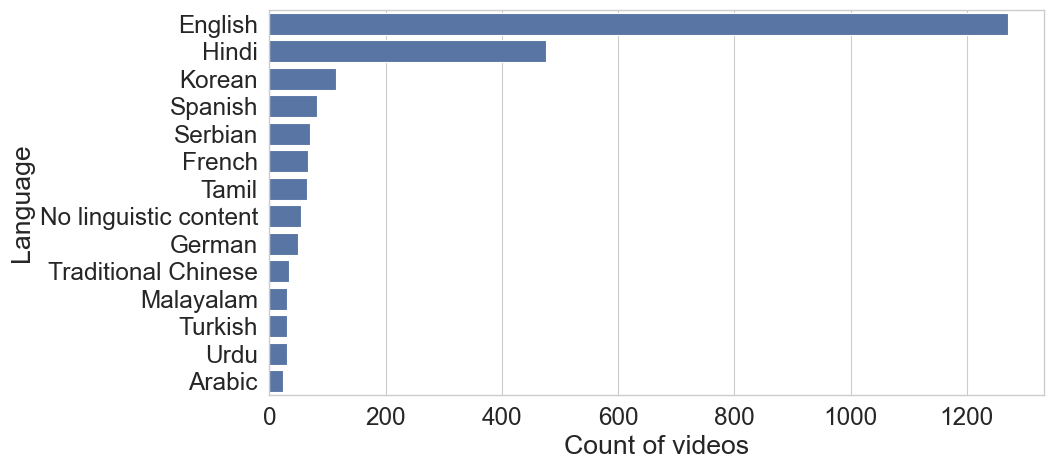

In [32]:
fig = plt.figure(figsize=(10,5))
sns.set_theme(style='whitegrid', context='paper', font_scale=2)
g = sns.barplot(
    x = yt_langdist.values,
    y = yt_langdist.index,
    # palette='viridis'
)
# plt.title('Distribution of Archived Site Types in')
# g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right');
plt.xlabel('Count of videos')
plt.ylabel('Language')
savepath = plot_path / f"YT_lang_dist.png"
plt.savefig(savepath, bbox_inches='tight', dpi=300)
logger.info(f'Saved to {savepath}')


# fig, ax = plt.subplots()
# fig.set_figwidth(10)
# fig.set_figheight(5)
# ax.set_ylabel('Count of videos')
# ax.set_title('Language distributions of videos')
# df['defaultLAudioLanguage'].value_counts().head(20).plot(ax=ax, kind='bar')
# ax.set_xlabel('Language')
# fig.savefig(plot_path / 'YT_lang_dist.png', bbox_inches='tight', dpi=800)

In [ ]:
fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(10)
ax.set_ylabel('Count of videos')
ax.set_title('Duration histogram')
ax.set_yscale('log')
df['durationSec'].value_counts().hist(bins=30)

In [ ]:
df.head()

### TT


In [ ]:
df['description_lang'].value_counts()

In [ ]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
df['description_lang'].value_counts().plot(ax=ax, kind='bar')

In [ ]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
ax.set_ylabel('Count of videos in sample')
AUT_COUNT = df['author_id'].value_counts()>=10
AUTS = AUT_COUNT[AUT_COUNT].index
df[df['author_id'].apply(lambda x: x in AUTS)]['author_id'].value_counts().plot(ax = ax, kind='bar')

In [ ]:
df[df['author_id']==AUTS[0]]

# Execute Clustering

## Basic Clustering

In [ ]:
if SYSTEM == 'linux':
    model_path = '/data/inet-large-scale-twitter-diffusion/ball4321/data_b/04_models/LaBSE'
else:
    model_path = 'LaBSE'
embedding_model = SentenceTransformer(model_path)

# Step 2 - Reduce dimensionality.
umap_model = UMAP(
    n_neighbors=10,
    n_components=5,
    min_dist=0.0,
    metric='cosine',
    random_state=42,
    verbose=True
)

# Step 3 - Cluster reduced embeddings.
dbscan_model = HDBSCAN(
    min_cluster_size=10,
    # min_samples=50,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

# Step 4 - Tokenize topics.
vectorizer_model = CountVectorizer(
    stop_words="english"
)

# Step 5 - Create topic representation.
ctfidf_model = ClassTfidfTransformer(
    # # seed_words = ['#MeToo', 'metoo', 'sexual', 'assault', 'niunamenos'],
    # seed_words = [
    #     "metoo", "BalanceTonPorc", "MoiAussi", "نه_یعنی_نه", "米兔", "我也是", 
    #     "وأنا كمان", "GamAni", "TôiCũngVậy", "私も", "WatashiMo", "나도", 
    #     "나도당했다", "גםאנחנו", "Ятоже", "RiceBunny", "EnaZeda", "AnaKaman", 
    #     "YoTambien", "SendeAnlat", "KuToo", "WithYou", "WeToo", "cuentalo", 
    #     "QuellaVoltaChe", "NiUnaMenos", "WoYeShi", "MyHarveyWeinstein", 
    #     "NousToutes", "stilleforopptak", "nårdansenstopper", "nårmusikkenstilner", 
    #     "memyös", "timesup", "NiEre", "JoTambe", "미투", "운동",
    #     'sexual', 'violence', 'assault', 'feminism'
    # ],
    # seed_multiplier=3
)

In [ ]:
topic_model = BERTopic(
    language='multilingual', # Set to 'multilingual' for datasets with languages other than English. N.B. documentation says this is not used if embedding_model is provided
    top_n_words=10,
    n_gram_range=(1, 3),
    # min_topic_size=10,
    nr_topics='50',
    low_memory=False,
    calculate_probabilities=False, # The probabilities of all topics per document. Might need to set to false for gpu https://github.com/rapidsai/cuml/issues/5127. see also https://github.com/rapidsai/cuml/issues/4879
    seed_topic_list=None, # Like CorEx
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=dbscan_model,
    vectorizer_model=vectorizer_model,
    ctfidf_model=ctfidf_model,
    verbose=True
)

In [ ]:
df.columns

In [ ]:
if YT_or_TT == 'YT':
    docs = df_long['text']
else:
    docs = df['description']


# get embeddings
embeddings = embedding_model.encode(docs.to_numpy(), show_progress_bar=True)


In [ ]:
# docs = df[df['description_lang']=='en']['description']
# docs = df['description']
out = topic_model.fit_transform(docs, embeddings=embeddings)

In [ ]:
import bertopic
bertopic.__version__

In [ ]:
topic_model.get_topic_info(-1)

In [ ]:
topic_model.visualize_topics()

In [ ]:
docs = df['description']
hierarchical_topics = topic_model.hierarchical_topics(docs)

In [ ]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [ ]:
topic_model.visualize_documents(docs, embeddings=embeddings)

In [ ]:
topic_model.representative_docs_[0]

In [ ]:
# When you used `.fit`:
topic_df = pd.DataFrame({"Document": docs, "Topic": topic_model.topics_})


In [ ]:
topic_df[topic_df['Topic'] == 0]

## Zero-shot clustering

### Setup

In [27]:
def align_configs(conf1, conf2):
    #align conf2 to conf1

    final_conf = {}
    seen = set()
    for k, v in conf2.items():
        for i, j in conf1.items():
            if v==j:
                final_conf[i] = j
                seen.add(k)
    for k, v in conf2.items():
        if k not in seen:
            final_conf[max(final_conf.keys())+1] = v

    return final_conf

In [9]:
cluster_params_file = DATA_PATH/'YT/cluster_params.pkl'
if not os.path.isfile(cluster_params_file) or overwrite:

    # Definitions for the configuration
    doctype_options = ['td', 'tdt']
    zeroshot_min_similarity_options = [0.8, 0.85, 0.9, 0.95, 0.7, 0.75]  # Complete range
    umap_n_neighbors_options = [2, 3]
    umap_n_components_options = [2, 3, 4]

    # Assuming other_params holds the rest of the fixed parameters (redefined due to reset)
    other_params = {
        'longorno': 'long',
        'zeroshot_topic_list': [
            '#MeToo movement, disclosures, survivors, sexual assault, rape, and violence allegations and feminism',
            'latestmalayalamnews, latest news, breaking',
            'jimin kpop #withyou song dance'
        ],
        'hdbscan_min_cluster_size': 10,
        'hdbscan_min_samples': 50,
        'main_min_topic_size': 5
    }

    # Reinitializing configurations dictionary to include both original and new configurations
    configurations = {}

    config_id = 1
    for doctype in doctype_options:
        for zeroshot_min_similarity in zeroshot_min_similarity_options:
            for umap_n_neighbors in umap_n_neighbors_options:
                for umap_n_components in umap_n_components_options:
                    configurations[config_id] = {
                        'doctype': doctype,
                        'zeroshot_min_similarity': zeroshot_min_similarity,
                        'umap_n_neighbors': umap_n_neighbors,
                        'umap_n_components': umap_n_components,
                        **other_params
                    }
                    config_id += 1

    old_params_file = DATA_PATH / 'YT/cluster_old_params.pkl'
    with open(old_params_file, 'rb') as f:
        old_params = pickle.load(f)

    params = align_configs(old_params, configurations)

    for i in range(1,17):
        assert params[i]==old_params[i]

    with open(cluster_params_file, 'wb') as f:
        pickle.dump(params, f)
    logger.info(f'File saved to {cluster_params_file}')
else:
    logger.info(f'{cluster_params_file} already exists')
    with open(cluster_params_file, 'rb') as f:
        params = pickle.load(f)
    logger.info(f'Loaded in')

params_df = pd.DataFrame.from_dict(params, orient='index')

param_num = 1
logger.info(f'Param num is {param_num}')
doctype = params[param_num]['doctype']
longorno = params[param_num]['longorno']
zeroshot_topic_list = params[param_num]['zeroshot_topic_list']

2024-03-14 12:47:54.922 | INFO     | __main__:<module>:53 - ../local_nogit/Data/YT/cluster_params.pkl already exists
2024-03-14 12:47:54.925 | INFO     | __main__:<module>:56 - Loaded in
2024-03-14 12:47:54.941 | INFO     | __main__:<module>:61 - Param num is 1


In [29]:
def execute_model(params, param_num, verbose = False):
    logger.info(f'Param num is {param_num} of {len(params)}')
    doctype = params[param_num]['doctype']
    logger.info(f"Doctype: {doctype}")
    longorno = params[param_num]['longorno']
    zeroshot_topic_list = params[param_num]['zeroshot_topic_list']

    # Step 1 - Get embeddings
    if YT_or_TT == 'YT':
        logger.info(f"Long or short df: {longorno}")
        if longorno == 'long':
            docs = df_long[doctype]
        else:
            docs = df_shorts[doctype]
        embed_savepath = DATA_PATH / f"YT/embed_df_{longorno}_{doctype}.npy"

    else:
        docs = df['description']
        embed_savepath = DATA_PATH / f"TikTok/01_raw/embed_df_{doctype}.npy"

    if not os.path.isfile(embed_savepath) or overwrite:
        embedding_model = SentenceTransformer('intfloat/multilingual-e5-large')
        embeddings = embedding_model.encode(docs.to_numpy(), show_progress_bar=True)
        np.save(embed_savepath, embeddings)
        logger.info(f'Saved to {embed_savepath}')
    else:
        embeddings = np.load(embed_savepath)
        logger.info(f'Loaded in from {embed_savepath}')

    # Step 2 - Reduce dimensionality.
    umap_model = UMAP(
        n_neighbors=params[param_num]['umap_n_neighbors'],
        n_components=params[param_num]['umap_n_components'],
        min_dist=0.0,
        metric='cosine',
        random_state=42,
        verbose=verbose
    )

    # Step 3 - Cluster reduced embeddings.
    dbscan_model = HDBSCAN(
        min_cluster_size=params[param_num]['hdbscan_min_cluster_size'],
        min_samples=params[param_num]['hdbscan_min_samples'],
        metric='euclidean',
        cluster_selection_method='eom',
        prediction_data=True
    )

    # Step 4 - Tokenize topics.
    vectorizer_model = CountVectorizer(
        stop_words=final_stopwords_list
    )

    # We fit our model using the zero-shot topics
    # and we define a minimum similarity. For each document,
    # if the similarity does not exceed that value, it will be used
    # for clustering instead.
    topic_model = BERTopic(
        embedding_model="intfloat/multilingual-e5-large",
        language = 'multilingual',
        min_topic_size=params[param_num]['main_min_topic_size'],
        zeroshot_topic_list=zeroshot_topic_list,
        zeroshot_min_similarity=params[param_num]['zeroshot_min_similarity'],
        representation_model=KeyBERTInspired(),
        umap_model = umap_model,
        hdbscan_model = dbscan_model,
        vectorizer_model = vectorizer_model,
        verbose=verbose
    )

    topics, _ = topic_model.fit_transform(docs, embeddings=embeddings)
    topics_2, probs = topic_model.transform(docs, embeddings = embeddings)

    return topic_model, topics, topics_2, probs

### Individual Execution

In [162]:
topic_model, topics, topics_2, probs = execute_model(params, 9, verbose=True)

2024-02-19 17:52:51.445 | INFO     | __main__:execute_model:2 - Param num is 9 of 72
2024-02-19 17:52:51.446 | INFO     | __main__:execute_model:4 - Doctype: tdt
2024-02-19 17:52:51.446 | INFO     | __main__:execute_model:10 - Long or short df: long
2024-02-19 17:52:51.458 | INFO     | __main__:execute_model:28 - Loaded in from ../local_nogit/Data/YT/embed_df_long_tdt.npy
2024-02-19 17:52:51.471 | INFO     | sentence_transformers.SentenceTransformer:__init__:66 - Load pretrained SentenceTransformer: intfloat/multilingual-e5-large
2024-02-19 17:52:59.232 | INFO     | sentence_transformers.SentenceTransformer:__init__:105 - Use pytorch device: cpu
2024-02-19 17:52:59,235 - BERTopic - Zeroshot Step 1 - Finding documents that could be assigned to either one of the zero-shot topics
2024-02-19 17:52:59,637 - BERTopic - Zeroshot Step 1 - Completed ✓
2024-02-19 17:52:59,638 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_neighbors=2, random_state=42, verbose=True)
Mon Feb 19 17:52:59 2024 Construct fuzzy simplicial set
Mon Feb 19 17:53:00 2024 Finding Nearest Neighbors
Mon Feb 19 17:53:00 2024 Finished Nearest Neighbor Search
Mon Feb 19 17:53:00 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

2024-02-19 17:53:01,136 - BERTopic - Dimensionality - Completed ✓
2024-02-19 17:53:01,136 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-19 17:53:01,149 - BERTopic - Cluster - Completed ✓
2024-02-19 17:53:01,151 - BERTopic - Representation - Extracting topics from clusters using representation models.


	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Feb 19 17:53:01 2024 Finished embedding


2024-02-19 17:53:23,875 - BERTopic - Representation - Completed ✓
2024-02-19 17:53:24,200 - BERTopic - Zeroshot Step 2 - Clustering documents that were not found in the zero-shot model...
2024-02-19 17:53:24,207 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-02-19 17:53:24,208 - BERTopic - Dimensionality - Completed ✓
2024-02-19 17:53:24,215 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-19 17:53:24,216 - BERTopic - Cluster - Completed ✓
2024-02-19 17:53:24,219 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-02-19 17:53:46,628 - BERTopic - Representation - Completed ✓
2024-02-19 17:53:47,119 - BERTopic - Zeroshot Step 2 - Completed ✓
2024-02-19 17:53:47,120 - BERTopic - Zeroshot Step 3 - Combining clustered topics with the zeroshot model
2024-02-19 17:53:47.136 | INFO     | sentence_transformers.SentenceTransformer:__init__:66 - Load pretrained SentenceTransformer: intfloat/multil

In [163]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,1128,"#MeToo movement, disclosures, survivors, sexua...","[allegations, metoo, talking, harassment, abus...",[query: Russell Brand: Trial by Media?Join us ...
1,1,990,"latestmalayalamnews, latest news, breaking","[latestmalayalamnews, vrithanthamthenews, news...",[query: ഹമാസിന്റെ തമ്പുരാട്ടി പടമായി😂😂😂Latestn...
2,2,586,jimin kpop #withyou song dance,"[withyou, instagram, lyrics, tiktok, video, bo...",[query: With You - Chris Brown (Lyrics) 🎵 | 25...
3,3,411,-1_poniji_ekvestrije_stvarno_prijateljima,"[poniji, ekvestrije, stvarno, prijateljima, pi...",[query: Moj Mali Poni 🦄 Spavati Otvorenih Očij...
4,4,278,0_scorpio_like_love_sorry,"[scorpio, like, love, sorry, video, coming, yo...",[query: Capricorn♑️ Everyone Hates Them! Now T...
5,5,61,1_fortnite_prijatelje_youtube_video,"[fortnite, prijatelje, youtube, video, pubg, s...",[query: Moj Mali Poni na srpskom 🦄 Moram da Po...


In [164]:
df_long[f'topics_{param_num}'] = topics
df_long[f'topics_tf_{param_num}'] = topics_2
df_long[f'probs_{param_num}']  = probs

# topics_df = topic_model.get_topic_info()
# topics_df

In [165]:
(topic_outputs_df_existing['topics_tf_9']==topics_2).sum()

2980

### Series Modeling

In [198]:
df_long.index.dtype

dtype('O')

In [28]:
# run for getting all params
# start = min(list(params.keys()))
# end = max(list(params.keys()))
topic_model_output_savepath = DATA_PATH/f'YT/topic_cluster_df_{longorno}.parquet'

if os.path.isfile(topic_model_output_savepath):
    topic_outputs_df_existing = pd.read_parquet(topic_model_output_savepath)
    logger.info(f'Loaded in from {topic_model_output_savepath}')
    common_cols = df_long.columns.intersection(topic_outputs_df_existing.columns)
    if len(common_cols) != len(topic_outputs_df_existing):

        # Exclude common columns from the right DataFrame (df2) in the merge
        # Note: This excludes the index if it's also a column, adjust if you're joining on a column instead of an index
        df2_excluded = topic_outputs_df_existing.drop(columns=common_cols, errors='ignore')
        df_long = pd.merge(df_long, topic_outputs_df_existing, left_index=True, right_index=True, how='outer')
else:
    logger.info('No previous file found, creating new.')
    topic_outputs_df_existing = None

topic_outputs = {'videoId': df_long.index}

at_least_one_was_new = False
for param_num in params.keys():

    # check if existing already
    if topic_outputs_df_existing is not None and f'topics_{param_num}' in topic_outputs_df_existing.columns:
        logger.info(f'Param set {param_num} done already, continuing...')
        # write appropriately
        continue
    else:
        at_least_one_was_new = True
        # continue

    logger.info(params[param_num])
    # execute model
    topic_model, topics, topics_2, probs = execute_model(params, param_num)

    df_long[f'topics_{param_num}'] = topics
    df_long[f'topics_tf_{param_num}'] = topics_2
    df_long[f'probs_{param_num}']  = probs

    topic_outputs[f'topics_{param_num}'] = topics
    topic_outputs[f'topics_tf_{param_num}'] = topics_2
    topic_outputs[f'probs_{param_num}'] = probs

# convert to df
topic_outputs_df = pd.DataFrame.from_dict(topic_outputs, orient='columns')
topic_outputs_df.set_index('videoId', inplace=True)

# combine results
if topic_outputs_df_existing is not None:
    topic_outputs_df = pd.merge(topic_outputs_df, topic_outputs_df_existing, left_index=True, right_index=True, how='outer') # Use the union of indexes from both DataFrames (keeps all rows from both DataFrames, filling in missing values with NaNs for non-overlapping index labels).

# save file
if not os.path.isfile(topic_model_output_savepath) or overwrite or topic_outputs_df_existing is not None:
    topic_outputs_df.to_parquet(topic_model_output_savepath)
    logger.info(f'Saved to {topic_model_output_savepath}')
else:
    logger.info(f'File already exists')

2024-03-14 13:01:37.458 | INFO     | __main__:<module>:8 - Loaded in from ../local_nogit/Data/YT/topic_cluster_df_long.parquet


2024-03-14 13:01:37.507 | INFO     | __main__:<module>:27 - Param set 1 done already, continuing...
2024-03-14 13:01:37.507 | INFO     | __main__:<module>:27 - Param set 2 done already, continuing...
2024-03-14 13:01:37.516 | INFO     | __main__:<module>:27 - Param set 3 done already, continuing...
2024-03-14 13:01:37.524 | INFO     | __main__:<module>:27 - Param set 4 done already, continuing...
2024-03-14 13:01:37.536 | INFO     | __main__:<module>:27 - Param set 5 done already, continuing...
2024-03-14 13:01:37.539 | INFO     | __main__:<module>:27 - Param set 6 done already, continuing...
2024-03-14 13:01:37.540 | INFO     | __main__:<module>:27 - Param set 7 done already, continuing...
2024-03-14 13:01:37.541 | INFO     | __main__:<module>:27 - Param set 8 done already, continuing...
2024-03-14 13:01:37.545 | INFO     | __main__:<module>:27 - Param set 17 done already, continuing...
2024-03-14 13:01:37.549 | INFO     | __main__:<module>:27 - Param set 18 done already, continuing..

NameError: name 'execute_model' is not defined

### Sandbox

In [31]:
topics_output_df = pd.read_parquet(topic_model_output_savepath)

In [32]:
topics_output_df

,topics_17,topics_tf_17,probs_17,topics_18,topics_tf_18,probs_18,topics_19,topics_tf_19,probs_19,topics_20,...,probs_13,topics_14,topics_tf_14,probs_14,topics_15,topics_tf_15,probs_15,topics_16,topics_tf_16,probs_16
videoId,,,,,,,,,,,,,,,,,,,,,
UbjuzpARrDU,2,2,0.912404,2,2,0.912404,2,2,0.912404,2,...,1.0,0,0,1.000000,-1,-1,0.0,1,1,1.000000
jLw9YDsn160,2,2,0.913843,2,2,0.913843,2,2,0.913843,2,...,0.0,0,0,0.816245,-1,-1,0.0,1,1,0.897926
FNpZlcYmUic,2,2,0.937154,2,2,0.937154,2,2,0.937154,2,...,0.0,0,0,1.000000,-1,-1,0.0,1,1,1.000000
sLpMq9kFBp8,2,2,0.916745,2,2,0.916745,2,2,0.916745,2,...,0.0,0,0,1.000000,-1,-1,0.0,1,1,1.000000
nOqyVdkaP60,2,2,0.917511,2,2,0.917511,2,2,0.917511,2,...,0.0,7,7,0.912797,-1,-1,0.0,7,7,0.953830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gg-EmI6ZrwQ,0,0,0.922519,0,0,0.922519,0,0,0.922519,0,...,0.0,5,5,0.611181,-1,-1,0.0,0,0,1.000000
xVTos5m_SS8,0,0,0.888720,0,0,0.888720,0,0,0.888720,0,...,0.0,7,7,0.462220,-1,-1,0.0,-1,-1,0.000000
kdj-c7pa5o0,0,0,0.900330,0,0,0.900330,0,0,0.900330,0,...,0.0,5,5,0.622477,-1,-1,0.0,0,0,1.000000


In [ ]:
topic_model.get_topic(0)

In [ ]:
topic_model.get_representative_docs(0)


In [ ]:
df_long['topics'] = topics

Examine by viewcount

In [ ]:
df_long[df_long['topics']==0].sort_values(by='viewCount', ascending=False)

Examine by probability in class:

In [167]:
rows_of_int = params_df.query('zeroshot_min_similarity == 0.80')
rows_of_int

,doctype,zeroshot_min_similarity,umap_n_neighbors,longorno,zeroshot_topic_list,umap_n_components,hdbscan_min_cluster_size,hdbscan_min_samples,main_min_topic_size
1,td,0.8,2,long,"[#MeToo movement, disclosures, survivors, sexu...",2,10,50,5
2,td,0.8,3,long,"[#MeToo movement, disclosures, survivors, sexu...",2,10,50,5
9,tdt,0.8,2,long,"[#MeToo movement, disclosures, survivors, sexu...",2,10,50,5
10,tdt,0.8,3,long,"[#MeToo movement, disclosures, survivors, sexu...",2,10,50,5
22,td,0.8,2,long,"[#MeToo movement, disclosures, survivors, sexu...",3,10,50,5
23,td,0.8,2,long,"[#MeToo movement, disclosures, survivors, sexu...",4,10,50,5
24,td,0.8,3,long,"[#MeToo movement, disclosures, survivors, sexu...",3,10,50,5
25,td,0.8,3,long,"[#MeToo movement, disclosures, survivors, sexu...",4,10,50,5
45,tdt,0.8,2,long,"[#MeToo movement, disclosures, survivors, sexu...",3,10,50,5
46,tdt,0.8,2,long,"[#MeToo movement, disclosures, survivors, sexu...",4,10,50,5


KeyError: 'topics_tf_24'

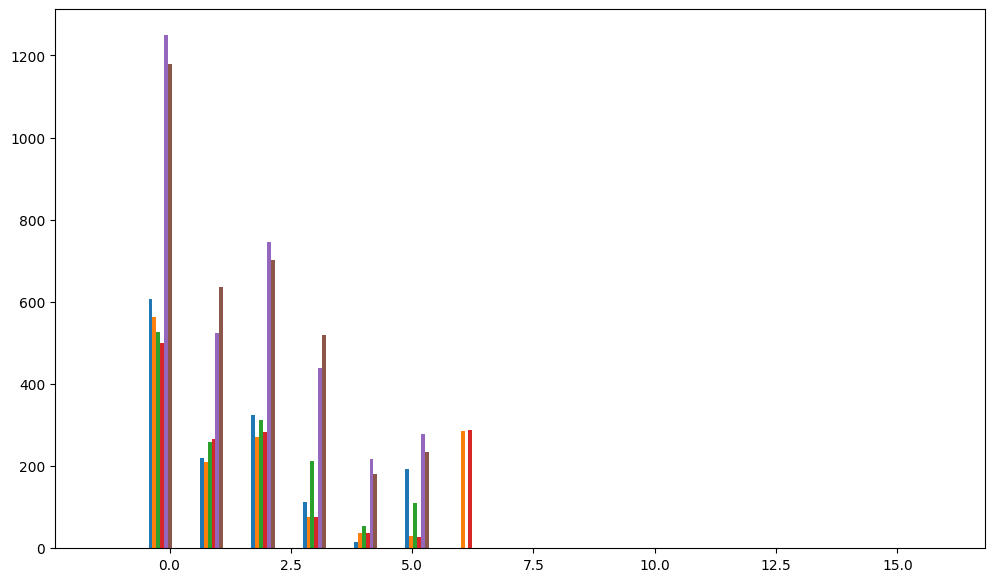

In [168]:
cols = rows_of_int.index
# Assuming df_long is your dataframe and cols contains the filtered column names

# Plotting parameters
n_bins = 18
bin_edges = np.linspace(-1.5, 16.5, n_bins)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
# Calculate bar width for no overlap within groups, considering some space for separation
bar_width = (bin_centers[1] - bin_centers[0]) / (len(cols) * 1.1)  # slightly reduce size for separation

plt.figure(figsize=(12, 7))

# Adjusted calculations for exaggerated separation
# Calculate the offset for each group to start, ensuring there is a gap between groups
offset = bar_width * len(cols) / 2
group_gap = bar_width * 0.5  # Additional gap between groups

# Plot each column
for index, val in enumerate(cols):
    # Calculate histogram
    counts, _ = np.histogram(df_long[f'topics_tf_{val}'], bins=bin_edges)

    # Calculate adjusted positions for each bar to ensure no overlap and exaggerated separation between groups
    adjusted_bin_centers = bin_centers - offset + index * bar_width + (group_gap * np.floor(index / len(cols)))

    # Plot
    plt.bar(adjusted_bin_centers, counts, width=bar_width, label=val)

plt.title('Side-by-Side Histograms with Exaggerated Separation')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.xticks(np.arange(-1, 17, 1))
plt.grid(True)
plt.show()


In [33]:
param_exam = 2

# get counts of classes
# df_long[f'topics_{param_exam}'].value_counts()
df_long[f'topics_tf_{param_exam}'].value_counts()

topics_tf_2
0    1262
6     704
2     637
1     521
3     176
5      82
4      72
Name: count, dtype: int64

In [34]:
df.columns

Index(['channelId', 'channelTitle', 'videoId', 'publishedAt', 'publishedAtSQL',
       'videoTitle', 'videoDescription', 'tags', 'videoCategoryId',
       'videoCategoryLabel', 'topicCategories', 'duration', 'durationSec',
       'dimension', 'definition', 'caption', 'defaultLanguage',
       'defaultLAudioLanguage', 'thumbnail_maxres', 'licensedContent',
       'locationDescription', 'latitude', 'longitude', 'viewCount',
       'likeCount', 'dislikeCount', 'favoriteCount', 'commentCount', 'text',
       'link'],
      dtype='object')

In [35]:
df_long['language_simplified'] = df_long['defaultLanguage'].apply(lambda x: x.split('-')[0] if x else 'None')

In [36]:
df_to_sample = df_long.query(f'topics_tf_{param_exam} == 0').sort_values(
    by=f'probs_{param_exam}',
    ascending=False
)

df_to_sample['language_simplified'].value_counts()

language_simplified
None    1025
en       170
es        12
de        11
zh         8
fr         6
ta         6
ml         3
iw         3
it         3
ko         2
ab         2
hi         2
ro         2
tl         1
ms         1
ja         1
ar         1
bn         1
ur         1
fi         1
Name: count, dtype: int64

In [37]:
len(df_to_sample)

1262

In [236]:
df_to_sample.sort_values(
    by=f'probs_{param_exam}',
    ascending=False
).head(30)[[
    'publishedAtSQL',
    'videoTitle',
    'videoDescription',
    'videoCategoryLabel',
    'defaultLanguage',
    # 'defaultLAudioLanguage',
    f'topics_tf_{param_exam}',
    f'probs_{param_exam}'
]]

,publishedAtSQL,videoTitle,videoDescription,videoCategoryLabel,defaultLanguage,topics_tf_2,probs_2
videoId,,,,,,,
TujnO5LsH8E,2023-11-22 05:20:34,A man convicted of taking part in a brazen plo...,A man convicted of taking part in a brazen plo...,People & Blogs,None,0,0.947465
s_SUneMZEsQ,2023-11-13 05:26:34,He needs his wheelchair to get in and out of s...,He needs his wheelchair to get in and out of s...,People & Blogs,None,0,0.945879
RNSjqY1SdRw,2023-11-25 23:55:34,"Cassie And Diddy Case Sparked ""Me Too"" Round Two","Cassie And Diddy Case Sparked ""Me Too"" Round T...",Entertainment,None,0,0.945860
_wUtdfWOGbU,2023-11-22 06:42:20,A man convicted of taking part in a brazen plo...,A man convicted of taking part in a brazen plo...,People & Blogs,None,0,0.945298
6sGrX4CKsCM,2023-11-22 05:36:03,Watch this truck driver pull an injured police...,Watch this truck driver pull an injured police...,People & Blogs,None,0,0.945116
wjIjOUKWEcI,2023-11-16 05:36:12,It's important to witness a man purposefully h...,It's important to witness a man purposefully h...,People & Blogs,None,0,0.945085
DyGfvkeHom0,2023-11-22 08:17:36,This truck driver pulling an injured police of...,This truck driver pulling an injured police of...,People & Blogs,None,0,0.944698
H2LAG-O-QLo,2023-11-16 05:25:14,It's not a good ending when a drugged-out craz...,It's not a good ending when a drugged-out craz...,People & Blogs,None,0,0.944571
BMewB8in_OM,2023-10-20 19:18:49,"Domestic Violence - Let's have another ""UNCOMF...","Join me this Sunday, at 6:00 PM PST as we talk...",Entertainment,None,0,0.944193


# YT Data Export

In [38]:
# Assuming df is your DataFrame and 'language_simplified' is the column of interest
# And min_samples is the minimum number of samples you want for each language

min_samples = 5  # Example minimum number of samples per language

language_counts = df_to_sample['language_simplified'].value_counts()

# Find languages that meet the minimum sample size criterion
languages_with_min_samples = language_counts[language_counts >= min_samples].index

# Filter the DataFrame to only include rows with languages having at least min_samples
temp_df = df_to_sample[df_to_sample['language_simplified'].isin(languages_with_min_samples)]

# Calculate the total number of samples needed
total_samples = len(temp_df)

# Get the distribution of languages
language_distribution = temp_df['language_simplified'].value_counts(normalize=True)
# distribution = temp_df['viewCount'].value_counts(normalize=True)


# Prepare a DataFrame to hold sampled rows
sampled_df = pd.DataFrame()


for language, proportion in language_distribution.items():
    # Determine the number of samples for this language, considering the minimum
    num_samples_for_language = max(min_samples, int(0.1*proportion * total_samples))

    # Sample rows for this language
    sampled_rows = temp_df[temp_df['language_simplified'] == language].sample(n=num_samples_for_language, weights='viewCount', replace=False, random_state=0)

    # Append to the sampled DataFrame
    sampled_df = pd.concat([sampled_df, sampled_rows])

# If the sampled DataFrame is larger than the desired total_samples due to minimum constraints,
# you may want to resample down to the desired size, possibly considering the original distribution


In [39]:
sampled_df['language_simplified'].value_counts()

language_simplified
None    102
en       17
es        5
de        5
zh        5
fr        5
ta        5
Name: count, dtype: int64

In [42]:
sampled_df

,channelId,channelTitle,publishedAt,publishedAtSQL,videoTitle,videoDescription,tags,videoCategoryId,videoCategoryLabel,topicCategories,...,topics_14,topics_tf_14,probs_14,topics_15,topics_tf_15,probs_15,topics_16,topics_tf_16,probs_16,language_simplified
videoId,,,,,,,,,,,,,,,,,,,,,
0bXt8Kjw1gc,UClDbIfQ-0nOBWtpbp81AtYA,Despot of Antrim,2023-11-09T12:41:41Z,2023-11-09 12:41:41,She Said: Hollywood's Humiliating #metoo Disaster,She Said might be the most hypocritical movie ...,"she said,harvey weinstein,hollywood,box office...",24,Entertainment,"Entertainment,Film",...,-1,-1,0.000000,-1,-1,0.000000,0,0,0.967187,None
TMVpC3a2M98,UCIPBqDkRYp8mNj1og5ff8gw,Cine Charm,2023-11-23T14:00:17Z,2023-11-23 14:00:17,Alok Nath Khan Me too Case | Sexual Harassment...,Alok Nath Khan Me too Case | Sexual Harassment...,"alok nath,me too case,sexual harassment,alok n...",24,Entertainment,"Entertainment,Film",...,10,10,0.742041,10,10,0.963831,-1,-1,0.000000,None
dzzO4LkpV_E,UCIpdf5xeAVNFKYnI8NyTOvQ,Laura Chaux,2023-11-25T23:53:57Z,2023-11-25 23:53:57,25 de noviembre INTERNACIONAL DE LA ELIMINACIÓ...,None,None,22,People & Blogs,Lifestyle_(sociology),...,4,4,0.899133,-1,-1,0.000000,5,5,0.861098,None
vvtuoHEsUts,UCDRURkcPv7wXwZd2BYR4P7g,NankatssufcTaraftar,2023-10-18T16:53:24Z,2023-10-18 16:53:24,sayfamiza destek olurmusunuz #galatasaray #def...,None,None,20,Gaming,"Association_football,Sport",...,-1,-1,0.000000,-1,-1,0.000000,-1,-1,0.000000,None
d9VmukLa6q0,UCMAtX9eFBpwc4LtgvbqsOpQ,CrowderBits,2023-10-03T21:00:30Z,2023-10-03 21:00:30,"""B*tch You Better Secure The Bag!"" - Trevor Ba...",Lindsey Hill shook down Trevor Bauer & now des...,"steven crowder,crowder,stephen crowder,crowder...",23,Comedy,"Politics,Society",...,-1,-1,0.000000,-1,-1,0.000000,-1,-1,0.000000,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MyJU3KBT74o,UCtHlpGrULkO3OxWhWsqcbkg,Alan Klindan,2023-11-14T12:19:01Z,2023-11-14 12:19:01,'Maya Lesbian -ஆ? Poornima -விடம் பழகுவது இதற்...,'Maya Lesbian -ஆ? Poornima -விடம் பழகுவது இதற்...,"alanklindan,Gaana Bala,Annabharathi,RJ Bravo,D...",24,Entertainment,"Entertainment,Film",...,11,11,0.398794,-1,-1,0.000000,16,16,1.000000,ta
_fgBx8AldcM,UC56COTKpiSfBzfyqYv6ucaw,Valai Pechu Anthanan,2023-11-19T06:54:13Z,2023-11-19 06:54:13,த்ரிஷா குறித்த மன்சூரலிகானின் ஆபாச பேச்சு! - த...,#thalapathy #mansooralikhan #trisha #vijay #le...,"trisha krishnan,trisha,thalapthy vijay,vijay f...",24,Entertainment,Society,...,11,11,0.555645,-1,-1,0.000000,14,14,1.000000,ta
uVafsSitO9E,UC_Vw0EbFhZ4c46KJeHB0uow,Bigg Boss Tamizh Review,2023-11-22T02:20:55Z,2023-11-22 02:20:55,APPRECIATING VICHITRA! Bigg Boss Tamil Season ...,#biggbosstamil #biggbosstamil7 #biggbossreview...,"Bigg Boss Tamil Season 7,Bigg Boss Tamil,Bigg ...",24,Entertainment,"Entertainment,Film",...,11,11,0.613751,11,11,1.000000,-1,-1,0.000000,ta


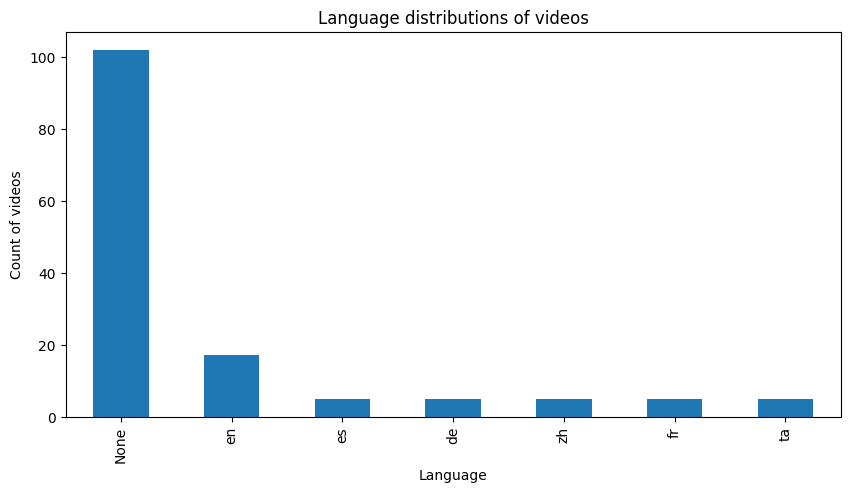

In [41]:
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(5)
ax.set_ylabel('Count of videos')
ax.set_title('Language distributions of videos')
sampled_df['language_simplified'].value_counts().head(20).plot(ax=ax, kind='bar')
ax.set_xlabel('Language')
fig.savefig(plot_path / 'YT_lang_dist_sample.png', bbox_inches='tight', dpi=800)

In [240]:
yt_analysis_savepath = DATA_PATH / f"YT/audio_transcribed_3.xlsx"
if not os.path.isfile(yt_analysis_savepath) or overwrite:
    sampled_df.to_excel(yt_analysis_savepath)
    logger.info(f'Saved to {yt_analysis_savepath}')
elif not overwrite:
    logger.info('Not overwriting')

2024-02-19 18:28:55.640 | INFO     | __main__:<module>:4 - Saved to ../local_nogit/Data/YT/audio_transcribed_3.xlsx
